# Amazon Analysis — Business Impact Notebook

Focus on:
4) Repeat buyers by price buckets
5) Potential churn signals (proxy)
6) Seasonality (if dates available)

**NOTE:** This notebook uses your dataset path exactly as requested.

In [1]:

# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Path as requested by user
DATA_PATH = r"C:\Users\DELL\Desktop\DA PROJECT\amazon.csv"

# Load
df = pd.read_csv(DATA_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))


Rows: 1465
Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']


In [2]:

# --- Cleaning numeric fields ---
def _clean_num(s, rm_percent=False):
    if pd.isna(s): return np.nan
    s = str(s).replace("₹","").replace(",","").strip()
    if rm_percent:
        s = s.replace("%","")
    return pd.to_numeric(s, errors="coerce")

for col in ["discounted_price","actual_price"]:
    if col in df.columns:
        df[col] = df[col].apply(_clean_num)

if "discount_percentage" in df.columns:
    df["discount_percentage"] = df["discount_percentage"].apply(lambda x: _clean_num(x, rm_percent=True))

if "rating" in df.columns:
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

if "rating_count" in df.columns:
    df["rating_count"] = pd.to_numeric(df["rating_count"].astype(str).replace({",":""}, regex=True), errors="coerce")

# Basic integrity
df = df.dropna(subset=["discounted_price", "actual_price"])
print(df[["discounted_price","actual_price","discount_percentage","rating","rating_count"]].head())


   discounted_price  actual_price  discount_percentage  rating  rating_count
0             399.0        1099.0                   64     4.2       24269.0
1             199.0         349.0                   43     4.0       43994.0
2             199.0        1899.0                   90     3.9        7928.0
3             329.0         699.0                   53     4.2       94363.0
4             154.0         399.0                   61     4.2       16905.0


In [4]:

# --- Price Buckets ---
bins = [0, 500, 1000, 5000, 10000, np.inf]
labels = ["0-500","500-1000","1000-5000","5000-10000","10000+"]
df["price_bucket"] = pd.cut(df["discounted_price"], bins=bins, labels=labels, include_lowest=True)
df["price_bucket"] = df["price_bucket"].astype(str)
df["is_discounted"] = (df["discount_percentage"].fillna(0) > 0) | (df["discounted_price"] < df["actual_price"])


## 4) Repeat buyers by price buckets

  price_bucket  users  repeat_rate
2       10000+     68     0.338235
0        0-500    447     0.154362
1    1000-5000    383     0.086162
4   5000-10000     75     0.066667
3     500-1000    221     0.063348


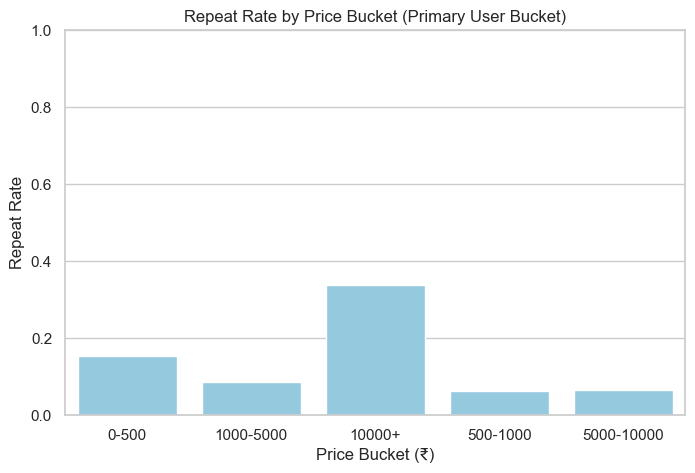

In [5]:

# Proxy for repeat buyer: multiple reviews/purchases by same user_id
assert "user_id" in df.columns, "user_id column is required for this analysis."
user_counts = df.groupby("user_id").size().rename("purchase_count").reset_index()
repeat_users = set(user_counts[user_counts["purchase_count"] > 1]["user_id"])

# Primary price bucket per user = mode bucket of their purchases
user_bucket = (df.groupby(["user_id","price_bucket"]).size()
                 .rename("cnt").reset_index())
user_bucket = user_bucket.sort_values(["user_id","cnt"], ascending=[True, False])
primary_bucket = user_bucket.groupby("user_id").first().reset_index()[["user_id","price_bucket"]]

primary_bucket["is_repeat"] = primary_bucket["user_id"].isin(repeat_users)
bucket_stats = (primary_bucket
                .groupby("price_bucket")
                .agg(users=("user_id","nunique"),
                     repeat_rate=("is_repeat", "mean"))
                .reset_index()
               )
print(bucket_stats.sort_values("repeat_rate", ascending=False))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=bucket_stats, x="price_bucket", y="repeat_rate", color="skyblue")
plt.title("Repeat Rate by Price Bucket (Primary User Bucket)")
plt.ylabel("Repeat Rate")
plt.xlabel("Price Bucket (₹)")
plt.ylim(0, 1)
plt.show()


## 5) Potential Churn Signals (proxy)

In [6]:

# Definition: one-purchase users + discounted + low price (<= ₹500)
low_threshold = 500
one_purchase_users = set(user_counts[user_counts["purchase_count"] == 1]["user_id"])

# Avg price and ever-discounted per user
avg_price = df.groupby("user_id")["discounted_price"].mean().rename("avg_price")
ever_disc = df.groupby("user_id")["is_discounted"].any().rename("ever_discounted")
churn_df = pd.concat([avg_price, ever_disc], axis=1).reset_index()
churn_df["purchase_count"] = churn_df["user_id"].map(dict(zip(user_counts["user_id"], user_counts["purchase_count"])))
churn_df["flag_churn"] = (churn_df["purchase_count"] == 1) & (churn_df["ever_discounted"] == True) & (churn_df["avg_price"] <= low_threshold)

flagged = churn_df[churn_df["flag_churn"] == True]
print("Flagged potential churn users:", len(flagged))
display(flagged.head(10))

# Save for CRM targeting
flagged.to_csv("potential_churn_users.csv", index=False)


Flagged potential churn users: 355


,user_id,avg_price,ever_discounted,purchase_count,flag_churn
0,"AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,AHWEYO2IJ5I5GDWZA...",239.0,True,1,True
2,AE242TR3GQ6TYC6W4SJ5UYYKBTYQ,399.0,True,1,True
7,"AE2TSJXRS5BXE6X7WFS7HOFJKCOQ,AEQTFT2S7RDVYEGOX...",230.0,True,1,True
11,"AE35OI7LDTOKU32IFQ3GQX5AOKFQ,AHT5CRFFKABTHYW4E...",448.0,True,1,True
12,"AE376Y5V3WTFCERMS7ZVYUZCFNUQ,AF5GSV6GVHTLGBTN2...",469.0,True,1,True
13,"AE3DRCI3U5PRSINPY2TZAU6JEWBA,AEOSTNYHDXDWBNGEZ...",499.0,True,1,True
14,"AE3GJ4N2G2K4Q6JXYPIQSH4344CQ,AFJMCZWWZZF4HZYT5...",199.0,True,1,True
15,"AE3JIMEZHC22EA7YZAUQF7VOUIFQ,AEHZS2RWOOR6UFKXA...",89.0,True,1,True
16,"AE3PTJFRVU3YM5YFYN3ICDA5X6FA,AGF5DMXE65QXZPJX6...",479.0,True,1,True
18,"AE3S2ZAEMH765KUJ57DR6HBZBB3Q,AHSIVUNTJMI5S5AJG...",272.0,True,1,True


## 6) Seasonality (if dates available)

In [7]:

# If the dataset has a purchase/review date column, plot monthly volume.
date_col = None
for c in df.columns:
    if "date" in c.lower():
        date_col = c
        break

if date_col is None:
    print("No date column found. Seasonality analysis is skipped.")
else:
    df["_date"] = pd.to_datetime(df[date_col], errors="coerce")
    monthly = df.dropna(subset=["_date"]).groupby(pd.Grouper(key="_date", freq="M")).size().rename("events").reset_index()
    print(monthly.head())

    plt.figure(figsize=(10,4))
    plt.plot(monthly["_date"], monthly["events"])
    plt.title("Monthly Activity (proxied by rows)")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


No date column found. Seasonality analysis is skipped.
